# Single-Task Learning on Cifar100 Dataset - Super-Class Classfication: A Vision Transformer Approach
- **Name**: Minh T. Nguyen & Peter Chen.
- **ECE 6524** - Final Project.
- **Date**: 4/22/2023.
- **Objective**: Build a Single Task model for image classification on Cifar100.

### References:
- Paper: ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929).
- [Author's Github Repository](https://github.com/google-research/vision_transformer).
- [Keras' Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

### Vision Transformers Architecture Explanation
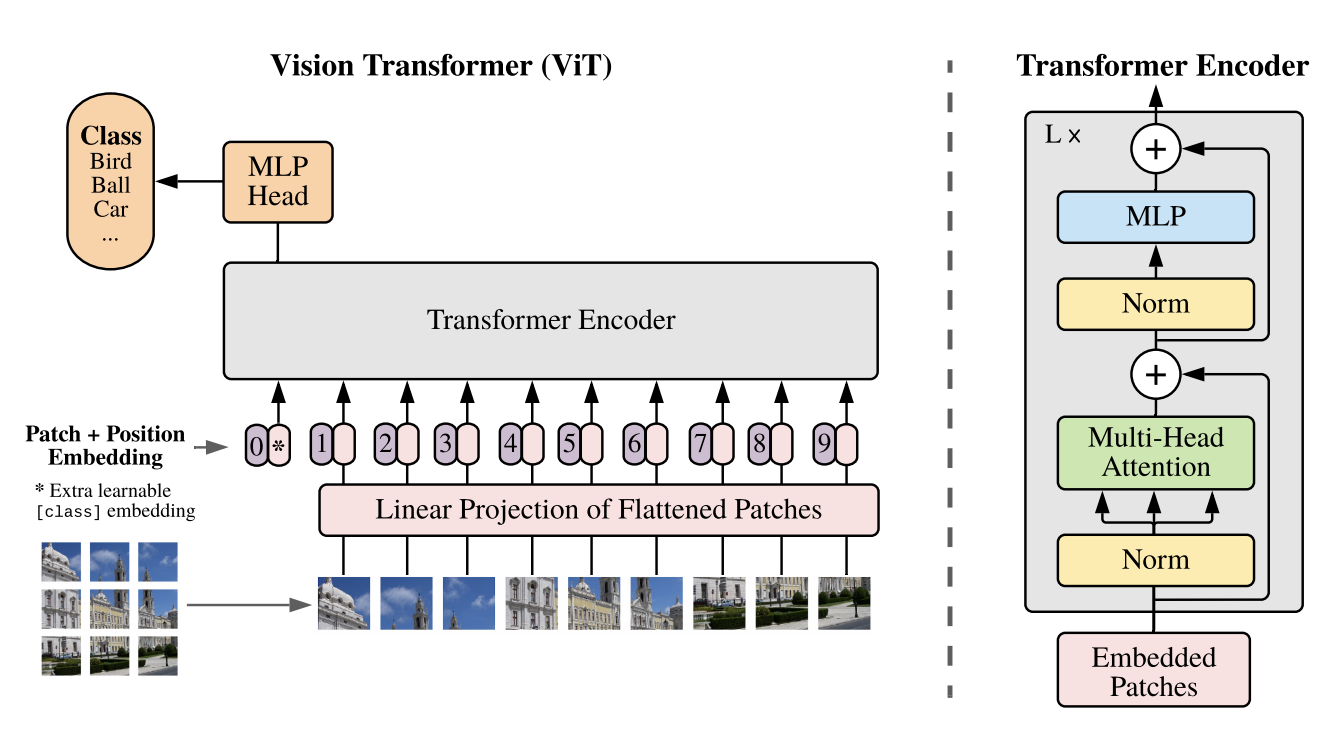

- **About**: Visions tasks were dominated by CNN-based architecture. However, Vision Transformers (ViT) has showed to be a high-capacity network architecture and can outperform CNN-based network on vision Tasks.
- **ViT Architecture**:
    - **Pipeline**: ViT computes the attentions between patches instead of image pixels due to limitation in computational power. **Input > Linear Projection > Stacked Encoder > MLP > Output Labels**
    - **Input Processing**: 
        - Convert Image to Patches.
        - Linear Projection: Each patch is reshaped to 1D vector, then we multiple with a learnable matrix to create a vector (patch linear projection). By doing for all patches, we will get an image linear projection.
        - Position Embedding: ViT is invariant to position on patches. For CNN, convolution is translation and scale equivariant (important for object detection) while pooling is translation and scale invariant (important for image recognition). By combining convolution and pooling, CNN can deal with recognition, object detection, and segmentation. Position embedding allow ViT to behave like CNN. This is the only inductive bias in ViT.  
    - **Transformers Encoder - Self-attention + MLP**:
        - Why do we have Layer Normalization? To reduce training time and stabilizes training phases.
        - Why do we use Skip Connection? To improves the performance by as much as 4% on recognition by propagating representation across layers.
        - Why do we use Multi-Head Self-Attention? To learn different representation of self-attention matrix to boost performance.
    - **MLP + Output**: Prediction outputs.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# import tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar100
from tensorflow.keras import layers
from tensorflow.keras import layers
from keras.utils import np_utils, plot_model

# 1. Data Visualization & Preprocessing
**Note**: This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class.

This means that the training set will have 500 images x 100 classes = 50k training dataset.


In [2]:
num_classes = 100          # number of classes
input_shape = (32, 32, 3) # original input image size
num_super_classes = 20     # number of super-classes

In [3]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode = 'coarse')

169001437/169001437 [==============================] - 2s 0us/step


In [4]:
# check dataset size
print(f"X={X_train.shape}, y={y_train.shape}")
print(f"X={X_test.shape}, y={y_test.shape}")

X=(50000, 32, 32, 3), y=(50000, 1)
X=(10000, 32, 32, 3), y=(10000, 1)


In [5]:
# check unique values
print(f"The unique values in the list is: {np.unique(np.array(y_train))}.")
print(f"The unique values in the list is: {np.unique(np.array(y_test))}.")

The unique values in the list is: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].
The unique values in the list is: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19].


In [6]:
# convert class into one hot encoder
y_train_super = np_utils.to_categorical(y_train, num_super_classes)
y_test_super = np_utils.to_categorical(y_test, num_super_classes)

In [7]:
# check shape
print(f"X={X_train.shape}, y={y_train_super.shape}")
print(f"X={X_test.shape}, y={y_test_super.shape}")

X=(50000, 32, 32, 3), y=(50000, 20)
X=(10000, 32, 32, 3), y=(10000, 20)


## 1.1. Data Visualization

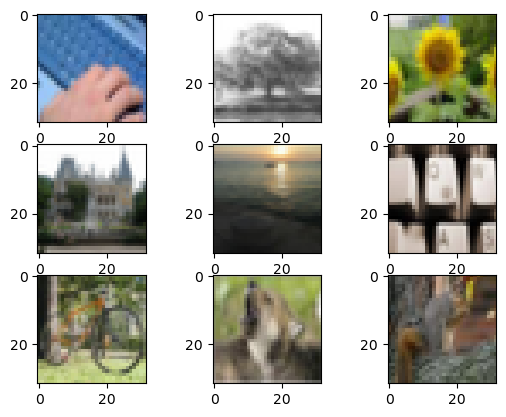

In [8]:
# plot the 9 images
f, axarr = plt.subplots(3,3)
axarr[0,0].imshow(X_train[10])
axarr[0,1].imshow(X_train[11])
axarr[0,2].imshow(X_train[12])
axarr[1,0].imshow(X_train[13])
axarr[1,1].imshow(X_train[14])
axarr[1,2].imshow(X_train[15])
axarr[2,0].imshow(X_train[16])
axarr[2,1].imshow(X_train[17])
axarr[2,2].imshow(X_train[18])
plt.show()

## 1.2. Superclass Generation
- **aquatic mammals** = beaver, dolphin, otter, seal, whale
- **fish** = aquarium fish, flatfish, ray, shark, trout
- **flowers** = orchids, poppies, roses, sunflowers, tulips
- **food containers** = bottles, bowls, cans, cups, plates
- **fruit and vegetables** = apples, mushrooms, oranges, pears, sweet peppers
- **household electrical devices** = clock, computer keyboard, lamp, telephone, television
- **household furniture** = bed, chair, couch, table, wardrobe
- **insects** = bee, beetle, butterfly, caterpillar, cockroach
- **large carnivores** = bear, leopard, lion, tiger, wolf
- **large man-made outdoor things** = bridge, castle, house, road, skyscraper
- **large natural outdoor scenes** = cloud, forest, mountain, plain, sea
- **large omnivores and herbivores** = camel, cattle, chimpanzee, elephant, kangaroo
- **medium-sized mammals** = fox, porcupine, possum, raccoon, skunk
- **non-insect invertebrates** = crab, lobster, snail, spider, worm
- **people** = baby, boy, girl, man, woman
- **reptiles** = crocodile, dinosaur, lizard, snake, turtle
- **small mammals** = hamster, mouse, rabbit, shrew, squirrel
- **trees** = maple, oak, palm, pine, willow
- **vehicles 1** = bicycle, bus, motorcycle, pickup truck, train
- **vehicles 2** = lawn-mower, rocket, streetcar, tank, tractor

## 1.3. Data Augmentation

In [9]:
# set images parameters
image_size = 72                                # resize image from 32x32x3 to 72x72x3
patch_size = 6                                 # each image will be divided into patch with each patches has size of 6x6
num_patches = (image_size // patch_size) ** 2  # total number of patches in an image

In [10]:
print(f"The total number of patches in an splitted image is {num_patches}.")

The total number of patches in an splitted image is 144.


In [11]:
# create a data augmentation layer
data_aug = keras.Sequential(
    [
        layers.Normalization(),                  # normalize image
        layers.Resizing(image_size, image_size), # resize image from 32x32x3 to 72x72x3
    ],
    name="data_augmentation",
)

# compute the mean and varaince of the training data for normalization
data_aug.layers[0].adapt(X_train)

## 1.4. Patch Transformation
**Note**: Convert an input image into a patch-dimension. The class Patch's job is to transform image to patch-dimension. For instance, with our input image as **(1, 72, 72, 3)** = (1 image, 72 width pixel, 72 height pixel, 3 color channel), the output will be **(1, 12, 12, 108)** = (1 image, 12 width patch, 12 height patch, 108 depth).

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        """Constructor"""
        super().__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        """Forward-pass function"""
        batch_size = tf.shape(images)[0]
        
        # pixel to patch conversion
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        
        # get depth
        patch_dims = patches.shape[-1]
        
        # resize
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

**Note**: Let's go through an example

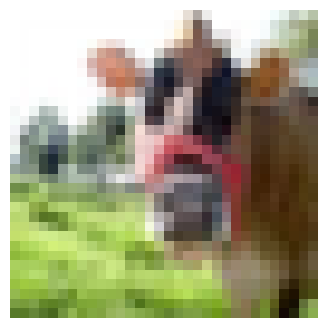

In [13]:
# plot original image
plt.figure(figsize=(4,4))
image = X_train[0]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.show()

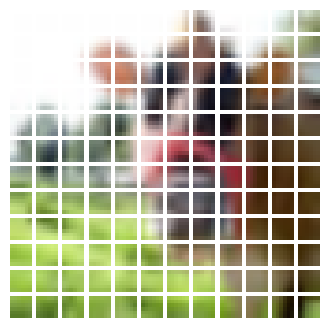

In [14]:
# resize and patch the image
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)

# get number of patch width (or height)
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

# patch the image and visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

**Note**: Let's get some calculated patches results after the transformation

In [15]:
print(f"Original image size: {image_size} x {image_size}.")
print(f"Calculated patch size: {patch_size} x {patch_size}.")
print(f"Number of patches per image: {patches.shape[1]}.")
print(f"Depth size of each patch: {patches.shape[-1]}.")

Original image size: 72 x 72.
Calculated patch size: 6 x 6.
Number of patches per image: 144.
Depth size of each patch: 108.


# 2. Modeling
**Note**: Build a Patch Encoding Layer and Build a Vision Transformers architecture.

In [16]:
# the size of the project dimension is just how depth the PatchEncoder layer prior to fetch to the Transformers
projection_dim = 64 

## 2.1. Patch Encoding Layer
**Note**: We will fetch each patch through a "Linear Projection of Flatten Patches" (aka, transform dimension via Dense layer) and attached the learnable Positional Embedding layer.

**Note**: Let's first visualize the positional embedding matrix. Each number is the position of each patch.

In [17]:
print(tf.range(start=0, limit=144, delta=1))

tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143], shape=(144,), dtype=int32)


In [18]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        """Constructor"""
        super().__init__()
        self.num_patches = num_patches                       # (12 x 12) = 144 patches
        self.projection = layers.Dense(units=projection_dim) # Dense layer that map the patched input to the projection_dim
        self.position_embedding = layers.Embedding(          # learnable embedding layer for the position (above)
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        """Forward Pass"""
        # create a position matrix
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        
        # resize the input patch with Dense
        input_patch = self.projection(patch)
        
        # encode position array with learnable embedding layer
        pos_emb = self.position_embedding(positions)
        
        # patch + position embedding
        encoded_patch = input_patch + pos_emb
        
        return encoded_patch

## 2.2. Vision Transformers
**Note**: Input > Linear Projection > Stacked Encoder > MLP > Output Labels

In [19]:
# training settings
batch_size = 256          # number of images per batch
num_heads = 4             # nummber of attention heads in the multi-attention layer
num_epochs = 20           # number of training epochs
transformer_dropout = 0.2 # dropout rate of mlp inner of transformers
mlp_dropout = 0           # dropout rate of mlp outside of transformers

# transformers settings
transformer_layers = 8    # number of stacked encoder layers

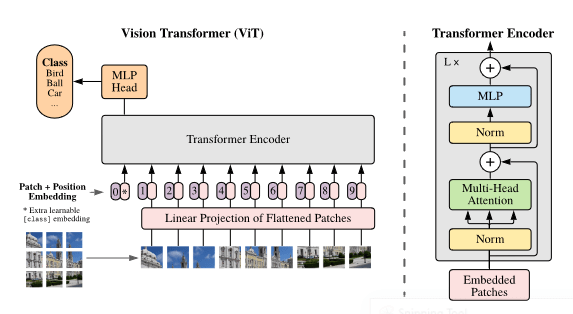

In [20]:
def create_model(mlp_dropout):
    # set input layer
    inputs = layers.Input(shape=input_shape)

    # normalize and resize image
    augmented = data_aug(inputs)

    # convert image's pixels into patches
    patches = Patches(patch_size)(augmented)

    # encode patch by linearly transform patch with dense and add the learnable position encoder
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # create stacked encoder
    for _ in range(transformer_layers):
        # layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # multi-head attention
        mtha = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # skip connection 1 = add input with mtha
        x2 = layers.Add()([mtha, encoded_patches])

        # layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x4 = layers.Dense(projection_dim * 2, activation=tf.nn.gelu)(x3)
        x4 = layers.Dropout(transformer_dropout)(x4)
        x4 = layers.Dense(projection_dim, activation=tf.nn.gelu)(x4)
        x4 = layers.Dropout(transformer_dropout)(x4)

        # skip connection 2
        encoded_patches = layers.Add()([x4, x2])

    # flatten transformers
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(mlp_dropout)(representation)
    features = layers.Dense(2048, activation=tf.nn.gelu)(representation)
    features = layers.Dropout(mlp_dropout)(features)
    features = layers.Dense(512, activation=tf.nn.gelu)(features)
    features = layers.Dropout(mlp_dropout)(features)
    features = layers.Dense(256, activation=tf.nn.gelu)(features)
    features = layers.Dropout(mlp_dropout)(features)
    features = layers.Dense(128, activation=tf.nn.gelu)(features)
    features = layers.Dropout(mlp_dropout)(features)
    output = layers.Dense(num_super_classes, activation='softmax')(features)
    
    # create model
    model = keras.Model(inputs=inputs, outputs=output)
    
    return model

In [21]:
# create a model
model = create_model(mlp_dropout=mlp_dropout)

In [22]:
# print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 3)   7           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      16192       ['patches_1[0][0]']              
                                                                                              

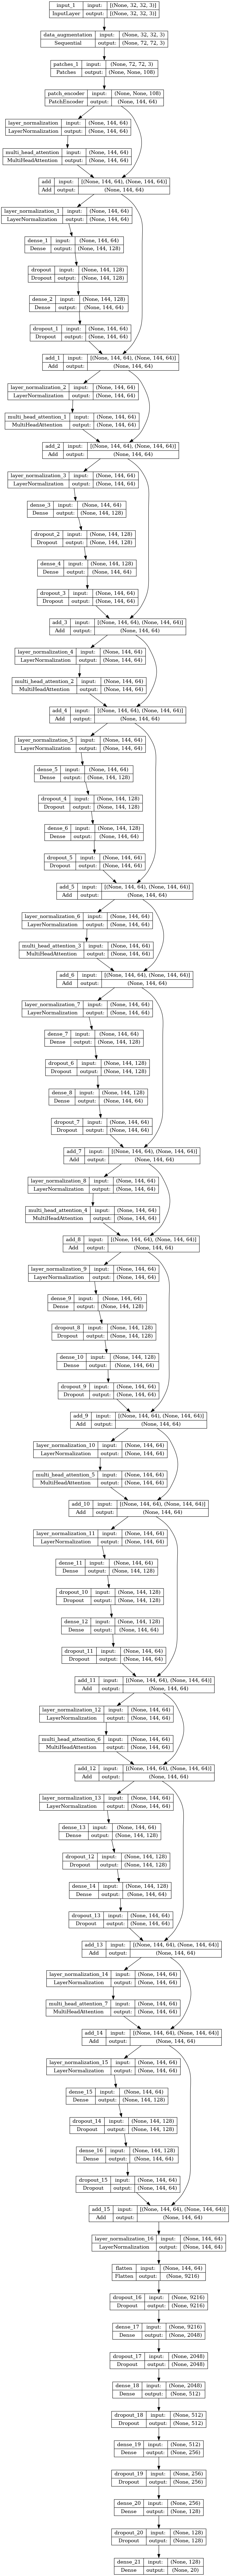

In [23]:
# plot architectures
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 2.3. Compile Model

In [24]:
# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 2.4. Train & Validate Model

In [25]:
# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

In [26]:
# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/20
167/167 [==============================] - 92s 365ms/step - loss: 2.3788 - accuracy: 0.2732 - val_loss: 2.2715 - val_accuracy: 0.3140
Epoch 2/20
167/167 [==============================] - 62s 369ms/step - loss: 1.9317 - accuracy: 0.4031 - val_loss: 2.1689 - val_accuracy: 0.3565
Epoch 3/20
167/167 [==============================] - 62s 374ms/step - loss: 1.6218 - accuracy: 0.4936 - val_loss: 2.0006 - val_accuracy: 0.4336
Epoch 4/20
167/167 [==============================] - 61s 368ms/step - loss: 1.2992 - accuracy: 0.5926 - val_loss: 2.0403 - val_accuracy: 0.4257
Epoch 5/20
167/167 [==============================] - 61s 368ms/step - loss: 0.8962 - accuracy: 0.7172 - val_loss: 2.1946 - val_accuracy: 0.4411
Epoch 6/20
167/167 [==============================] - 61s 368ms/step - loss: 0.5209 - accuracy: 0.8320 - val_loss: 2.5951 - val_accuracy: 0.4648
Epoch 7/20
167/167 [==============================] - 61s 368ms/step - loss: 0.2546 - accuracy: 0.9176 - val_loss: 2.8791 - val_ac

In [27]:
# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

Train loss: 0.03591831028461456
Train acc: 0.9889411926269531


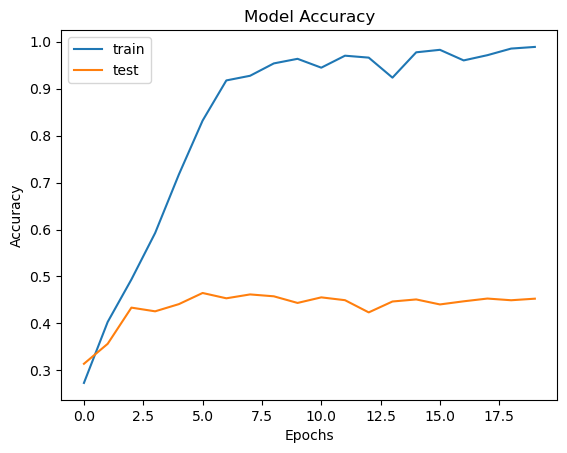

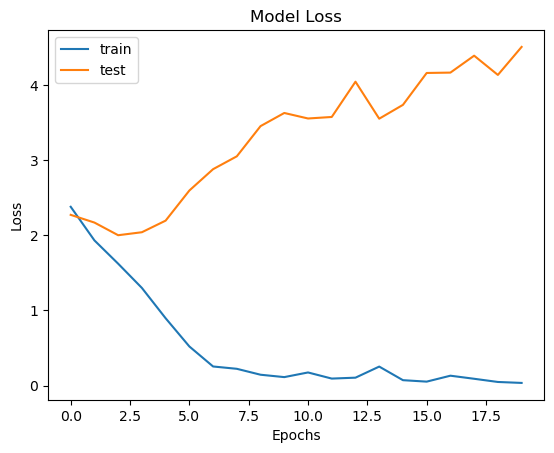

In [28]:
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2.5. Test Trained Model

In [29]:
# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 4.432138919830322
Test acc: 0.4578999876976013


# 3. Optimize ViT with Different Parameters

## 3.1. Case 1  - Batch Size = 256, Dropout-MLP=0, Adam Optimizer (Trained Aboved)

In [30]:
# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

Train loss: 0.03591831028461456
Train acc: 0.9889411926269531


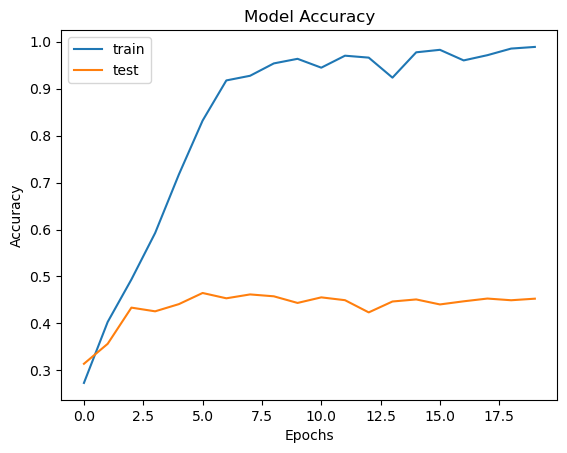

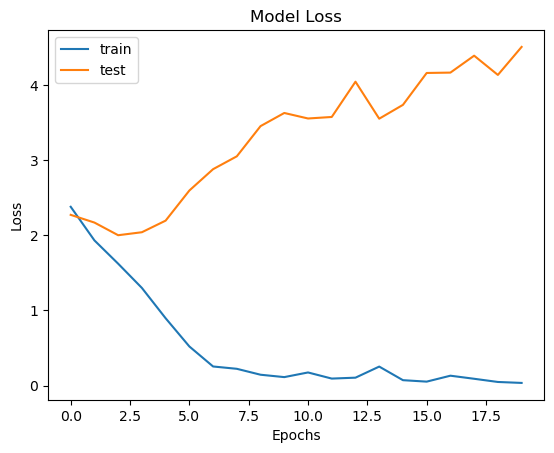

In [31]:
# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 4.432138919830322
Test acc: 0.4578999876976013


## 3.2. Case 2  - Batch Size = 128, Dropout-MLP=0, Adam Optimizer

Epoch 1/20
333/333 [==============================] - 94s 203ms/step - loss: 2.3851 - accuracy: 0.2671 - val_loss: 2.1484 - val_accuracy: 0.3531
Epoch 2/20
333/333 [==============================] - 66s 197ms/step - loss: 1.9442 - accuracy: 0.4002 - val_loss: 1.9803 - val_accuracy: 0.4096
Epoch 3/20
333/333 [==============================] - 66s 197ms/step - loss: 1.6027 - accuracy: 0.4967 - val_loss: 1.8549 - val_accuracy: 0.4435
Epoch 4/20
333/333 [==============================] - 66s 198ms/step - loss: 1.2460 - accuracy: 0.6063 - val_loss: 1.9519 - val_accuracy: 0.4687
Epoch 5/20
333/333 [==============================] - 66s 198ms/step - loss: 0.8210 - accuracy: 0.7390 - val_loss: 2.1709 - val_accuracy: 0.4612
Epoch 6/20
333/333 [==============================] - 66s 199ms/step - loss: 0.4551 - accuracy: 0.8525 - val_loss: 2.6169 - val_accuracy: 0.4588
Epoch 7/20
333/333 [==============================] - 65s 194ms/step - loss: 0.2821 - accuracy: 0.9080 - val_loss: 3.0284 - val_ac

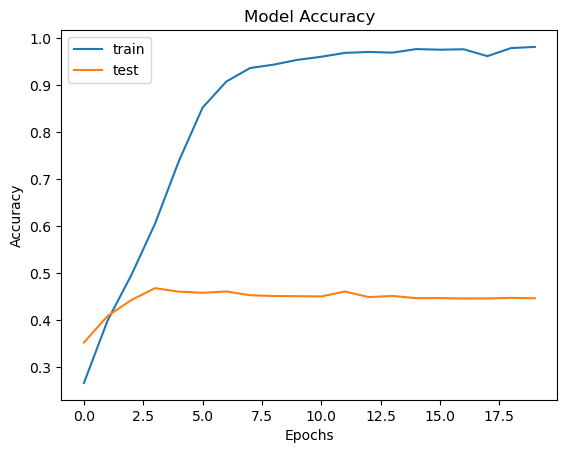

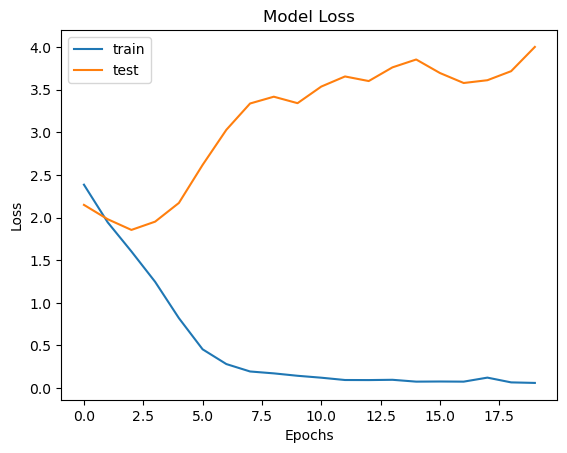

Test loss: 3.969761610031128
Test acc: 0.4480000138282776


In [33]:
# training settings
batch_size = 128          # number of images per batch
mlp_dropout = 0           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

## 3.3. Case 3  - Batch Size = 256, Dropout-MLP=0.5, Adam Optimizer

Epoch 1/20
167/167 [==============================] - 90s 384ms/step - loss: 3.0946 - accuracy: 0.0676 - val_loss: 2.8370 - val_accuracy: 0.1280
Epoch 2/20
167/167 [==============================] - 62s 374ms/step - loss: 2.8694 - accuracy: 0.1059 - val_loss: 2.7369 - val_accuracy: 0.1549
Epoch 3/20
167/167 [==============================] - 64s 384ms/step - loss: 2.7726 - accuracy: 0.1329 - val_loss: 2.6169 - val_accuracy: 0.1759
Epoch 4/20
167/167 [==============================] - 63s 378ms/step - loss: 2.6793 - accuracy: 0.1609 - val_loss: 2.6365 - val_accuracy: 0.1929
Epoch 5/20
167/167 [==============================] - 64s 384ms/step - loss: 2.6359 - accuracy: 0.1754 - val_loss: 2.5485 - val_accuracy: 0.2201
Epoch 6/20
167/167 [==============================] - 64s 383ms/step - loss: 2.5863 - accuracy: 0.1893 - val_loss: 2.5131 - val_accuracy: 0.2113
Epoch 7/20
167/167 [==============================] - 64s 384ms/step - loss: 2.5527 - accuracy: 0.2019 - val_loss: 2.4622 - val_ac

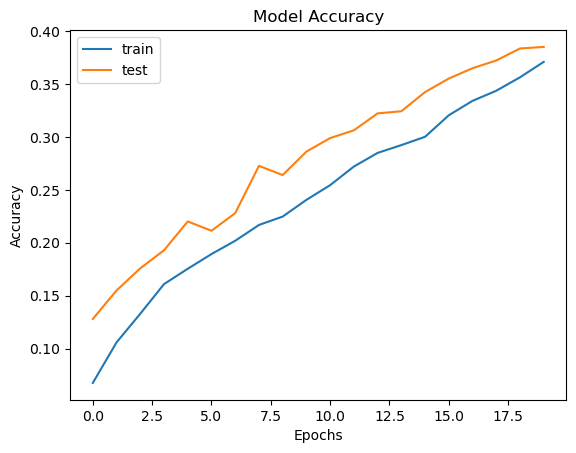

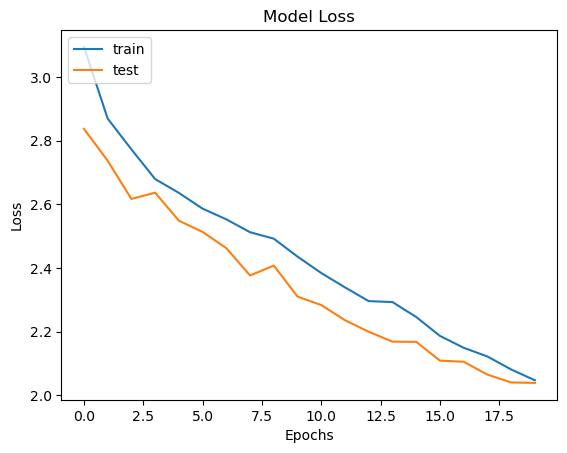

Test loss: 2.0235888957977295
Test acc: 0.3815000057220459


In [34]:
# training settings
batch_size = 256            # number of images per batch
mlp_dropout = 0.5           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

## 3.4. Case 4  - Batch Size = 256, Dropout-MLP=0, SGD Optimizer

Epoch 1/20
167/167 [==============================] - 80s 390ms/step - loss: 2.6788 - accuracy: 0.1820 - val_loss: 2.9920 - val_accuracy: 0.1487
Epoch 2/20
167/167 [==============================] - 63s 376ms/step - loss: 2.4083 - accuracy: 0.2590 - val_loss: 2.9984 - val_accuracy: 0.1887
Epoch 3/20
167/167 [==============================] - 63s 375ms/step - loss: 2.2784 - accuracy: 0.2976 - val_loss: 3.0516 - val_accuracy: 0.2141
Epoch 4/20
167/167 [==============================] - 63s 375ms/step - loss: 2.1892 - accuracy: 0.3275 - val_loss: 3.1976 - val_accuracy: 0.1909
Epoch 5/20
167/167 [==============================] - 63s 380ms/step - loss: 2.1147 - accuracy: 0.3475 - val_loss: 2.6688 - val_accuracy: 0.2544
Epoch 6/20
167/167 [==============================] - 63s 375ms/step - loss: 2.0400 - accuracy: 0.3687 - val_loss: 3.2000 - val_accuracy: 0.2145
Epoch 7/20
167/167 [==============================] - 61s 365ms/step - loss: 1.9857 - accuracy: 0.3891 - val_loss: 3.3960 - val_ac

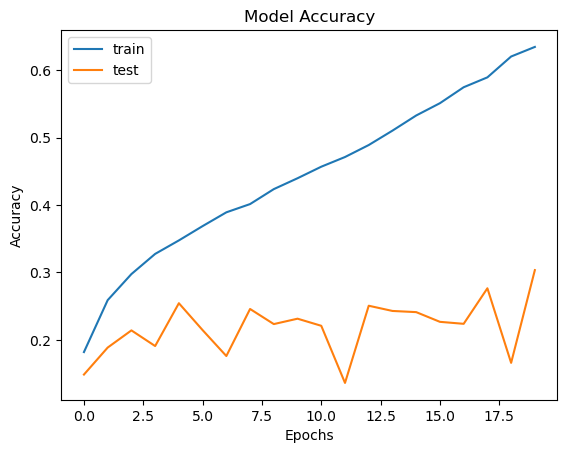

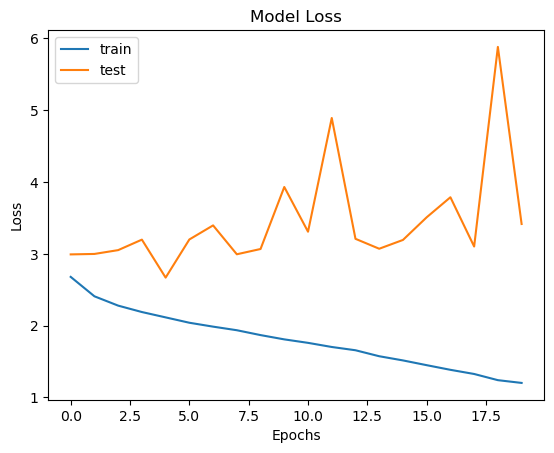

Test loss: 3.488494634628296
Test acc: 0.29980000853538513


In [35]:
# training settings
batch_size = 256          # number of images per batch
mlp_dropout = 0           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

## 3.5. Case 5  - Batch Size = 128, Dropout-MLP=0, SGD Optimizer

Epoch 1/20
333/333 [==============================] - 81s 205ms/step - loss: 2.5834 - accuracy: 0.2086 - val_loss: 2.6495 - val_accuracy: 0.2287
Epoch 2/20
333/333 [==============================] - 67s 200ms/step - loss: 2.2777 - accuracy: 0.2986 - val_loss: 2.4116 - val_accuracy: 0.2727
Epoch 3/20
333/333 [==============================] - 64s 194ms/step - loss: 2.1266 - accuracy: 0.3430 - val_loss: 2.4274 - val_accuracy: 0.2748
Epoch 4/20
333/333 [==============================] - 66s 198ms/step - loss: 2.0132 - accuracy: 0.3783 - val_loss: 2.7257 - val_accuracy: 0.2564
Epoch 5/20
333/333 [==============================] - 66s 198ms/step - loss: 1.9092 - accuracy: 0.4094 - val_loss: 2.5903 - val_accuracy: 0.2860
Epoch 6/20
333/333 [==============================] - 66s 198ms/step - loss: 1.8140 - accuracy: 0.4384 - val_loss: 2.4215 - val_accuracy: 0.3087
Epoch 7/20
333/333 [==============================] - 66s 198ms/step - loss: 1.7098 - accuracy: 0.4699 - val_loss: 2.9748 - val_ac

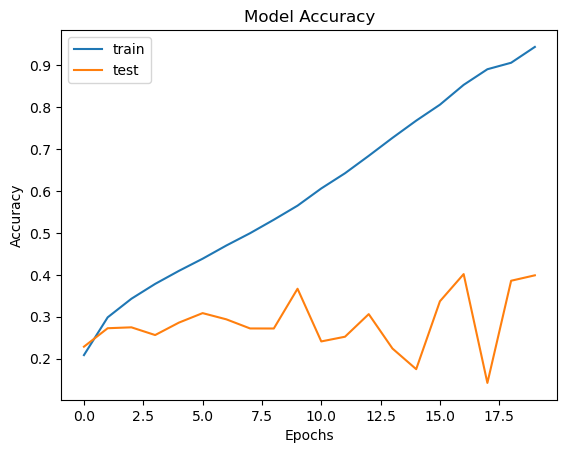

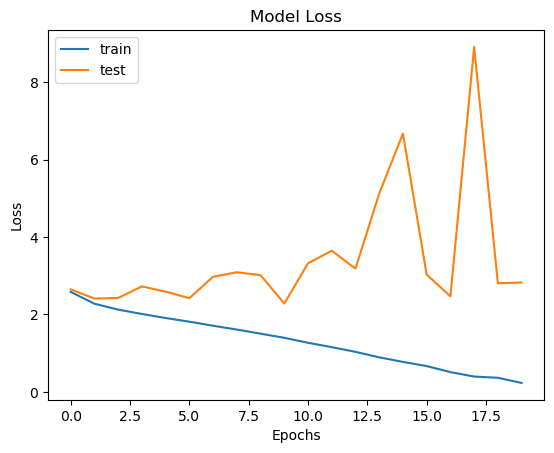

Test loss: 2.8406200408935547
Test acc: 0.3955000042915344


In [36]:
# training settings
batch_size = 128          # number of images per batch
mlp_dropout = 0           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)

## 3.6. Case 6  - Batch Size = 256, Dropout-MLP=0.5, SGD Optimizer

Epoch 1/20
167/167 [==============================] - 78s 389ms/step - loss: 3.4838 - accuracy: 0.0533 - val_loss: 2.9819 - val_accuracy: 0.0583
Epoch 2/20
167/167 [==============================] - 63s 380ms/step - loss: 3.0648 - accuracy: 0.0559 - val_loss: 2.9802 - val_accuracy: 0.0681
Epoch 3/20
167/167 [==============================] - 62s 369ms/step - loss: 3.0281 - accuracy: 0.0582 - val_loss: 2.9665 - val_accuracy: 0.1007
Epoch 4/20
167/167 [==============================] - 63s 379ms/step - loss: 3.0026 - accuracy: 0.0651 - val_loss: 2.9461 - val_accuracy: 0.1024
Epoch 5/20
167/167 [==============================] - 62s 370ms/step - loss: 2.9776 - accuracy: 0.0714 - val_loss: 2.9076 - val_accuracy: 0.0857
Epoch 6/20
167/167 [==============================] - 63s 379ms/step - loss: 2.9507 - accuracy: 0.0800 - val_loss: 2.8706 - val_accuracy: 0.1055
Epoch 7/20
167/167 [==============================] - 62s 371ms/step - loss: 2.9323 - accuracy: 0.0851 - val_loss: 2.8553 - val_ac

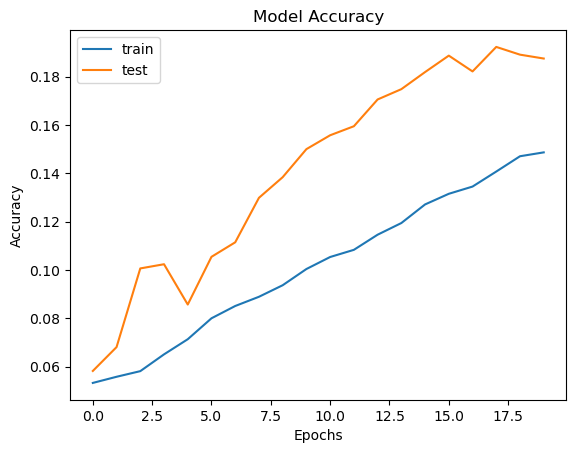

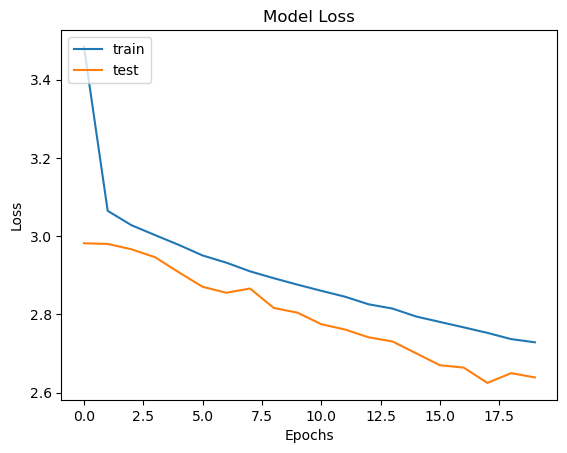

Test loss: 2.63242244720459
Test acc: 0.19130000472068787


In [37]:
# training settings
batch_size = 256            # number of images per batch
mlp_dropout = 0.5           # dropout rate of mlp outside of transformers

# create a model
model = create_model(mlp_dropout=mlp_dropout)

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# set up call backs (pickle the best model only!)
callbacks = [
  keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/base_model.keras",
    save_best_only=True,
    monitor="val_loss"
  )
]

# train and save in history for plotting
history = model.fit(
    x=X_train,
    y=y_train_super,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1,
)

# train model results
print('Train loss:', history.history['loss'][-1])
print('Train acc:', history.history['accuracy'][-1])

# accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# test model results
test_loss, test_acc = model.evaluate(X_test,y_test_super,
                       batch_size=batch_size,
                       verbose=0)
print('Test loss:', test_loss)
print('Test acc:', test_acc)